# General information

In Santander Customer Transaction Prediction competition we have a binary classification task. Train and test data have 200k samples each and we have 200 anonimyzed numerical columns. It would be interesting to try good models without overfitting and knowing the meaning of the features.
In fact this competition seems to be similar to another current competition: don't overfit II, so I'll use a lot of ideas from my [kernel](https://www.kaggle.com/artgor/how-to-not-overfit).

In this kernel I'll write the following things:

* EDA on the features and trying to get some insights;
* Using permutation importance to select most impactful features;
* Comparing various models: linear models, tree based models and others;
* Trying various approaches to feature selection including taking top features from eli5;
* Hyperparameter optimization for models;
* Feature generation;
* Other things;

![](https://i.imgur.com/e5vPHpJ.png)

*Work still in progress*

In [1]:
# Libraries
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime
import lightgbm as lgb
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb
import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import metrics
import json
import ast
import time
from sklearn import linear_model
import eli5
from eli5.sklearn import PermutationImportance
import shap
from tqdm import tqdm_notebook
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import GenericUnivariateSelect, SelectPercentile, SelectKBest, f_classif, mutual_info_classif, RFE
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from catboost import CatBoostClassifier

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
train.shape, test.shape

((200000, 202), (200000, 201))

## Data exploration

In [8]:
test.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,8.8100,-2.0248,-4.3554,13.9696,0.3458,7.5408,14.5001,7.7028,-19.0919,15.5806,16.1763,3.7088,18.8064,1.5899,3.0654,6.4509,14.1192,-9.4902,-2.1917,5.7107,3.7864,-1.7981,9.2645,2.0657,12.7753,11.3334,8.1462,-0.0610,3.5331,9.7804,8.7625,-15.6305,18.8766,11.2864,11.8362,13.3680,-31.9891,12.1776,8.7714,17.2011,16.8508,13.0534,14.4069,-4.8525,7.3213,-0.5259,16.6365,19.3036,6.4129,-5.3948,9.3269,11.9314,-3.5750,-0.7706,0.8705,6.9282,2.8914,5.9744,17.4851,5.0125,-1.4230,33.3401,0.8018,-4.7906,30.2708,26.8339,21.7205,7.3075,14.0810,3.1192,17.4265,9.4883,16.9060,14.5117,10.0276,-0.9706,20.4588,4.7945,20.4160,13.1633,7.9307,-7.6509,7.0834,15.2324,10.1416,5.9156,-0.5775,5.7600,30.3238,2.1251,1.8585,-9.2198,17.3089,30.9548,1.4918,12.8721,3.4902,8.2856,11.9794,14.0176,15.0763,3.7662,6.0426,4.4243,14.1799,2.0921,1.5493,3.2206,0.0172,-6.6602,8.4785,42.0248,11.4164,0.4564,9.4006,0.9685,12.4929,14.1240,4.0388,-4.4442,16.6684,12.5380,0.9205,10.5998,7.5147,-4.1748,-0.4824,10.5267,17.7547,-6.5226,-2.5502,-5.1547,-2.1246,19.8319,13.0752,9.2275,3.0213,11.6793,-11.6827,4.1017,5.2954,18.7741,9.8892,7.5219,14.9745,18.9880,1.0842,11.9125,-4.5103,16.1361,11.0067,5.9232,5.4113,3.8302,5.7380,-8.6105,22.9530,2.5531,-0.2836,4.3416,5.1855,4.2603,1.6779,29.0849,8.4685,18.1317,12.2818,-0.6912,10.2226,-5.5579,2.2926,-4.5358,10.3903,-15.4937,3.9697,31.3521,-1.1651,9.2874,-23.5705,13.2643,1.6591,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,5.9739,-1.3809,-0.3310,14.1129,2.5667,5.4988,14.1853,7.0196,4.6564,29.1609,0.0910,12.1469,3.1389,5.2578,2.4228,16.2064,13.5023,-5.2341,-3.6648,5.7080,2.9965,-10.4720,11.4938,-0.9660,15.3445,10.6361,0.8966,6.7428,2.3421,12.8678,-1.5536,10.0309,3.1337,10.5742,11.7664,2.1782,-41.1924,13.5322,-17.3834,6.3806,12.5589,11.6887,25.3930,1.5776,6.8481,8.7348,16.4239,21.7056,6.9345,1.6678,9.5249,5.3383,-18.7083,1.3382,-1.7401,5.8398,3.1051,4.4307,16.0005,5.0306,-7.3365,12.2806,0.6992,-0.7772,21.5123,6.7803,18.1896,6.9388,22.1336,6.3755,13.1525,1.9772,14.0406,6.6904,9.9732,-11.5679,20.4525,9.4951,9.6343,8.1252,2.6059,-17.4201,7.1848,15.3484,10.6522,5.9897,0.3392,10.3516,29.8204,1.9998,-1.4166,-1.7257,15.4712,35.6020,1.6570,13.0783,2.7752,6.4986,4.6835,13.7963,17.7261,1.7375,5.5689,3.6609,8.9725,4.1159,1.0693,2.0234,8.2760,-6.8610,0.2780,17.0488,11.6704,3.1215,8.5093,5.6367,12.0099,14.2372,-

In [3]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,4.6667,3.8743,-5.2387,7.3746,11.5767,12.0446,11.6418,-7.0170,5.9226,-14.2136,16.0283,5.3253,12.9194,29.0460,-0.6940,5.1736,-0.7474,14.8322,11.2668,5.3822,2.0183,10.1166,16.1828,4.9590,2.0771,-0.2154,8.6748,9.5319,5.8056,22.4321,5.0109,-4.7010,21.6374,0.5663,5.1999,8.8600,43.1127,18.3816,-2.3440,23.4104,6.5199,12.1983,13.6468,13.8372,1.3675,2.9423,-4.5213,21.4669,9.3225,16.4597,7.9984,-1.7069,-21.4494,6.7806,11.0924,9.9913,14.8421,0.1812,8.9642,16.2572,2.1743,-3.4132,9.4763,13.3102,26.5376,1.4403,14.7100,6.0454,9.5426,17.1554,14.1104,24.3627,2.0323,6.7602,3.9141,-0.4851,2.5240,1.5093,2.5516,15.5752,-13.4221,7.2739,16.0094,9.7268,0.8897,0.7754,4.2218,12.0039,13.8571,-0.7338,-1.9245,15.4462,12.8287,0.3587,9.6508,6.5674,5.1726,3.1345,29.4547,31.4045,2.8279,15.6599,8.3307,-5.6011,19.0614,11.2663,8.6989,8.3694,11.5659,-16.4727,4.0288,17.9244,18.5177,10.7800,9.0056,16.6964,10.4838,1.6573,12.1749,-13.1324,17.6054,11.5423,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,10.8160,3.6783,-11.1147,1.8730,9.8775,11.7842,1.2444,-47.3797,7.3718,0.1948,34.4014,25.7037,11.8343,13.2256,-4.1083,6.6885,-8.0946,18.5995,19.3219,7.0118,1.9210,8.8682,8.0109,-7.2417,1.7944,-1.3147,8.1042,1.5365,5.4007,7.9344,5.0220,2.2302,40.5632,0.5134,3.1701,20.1068,7.7841,7.0529,3.2709,23.4822,5.5075,13.7814,2.5462,18.1782,0.3683,-4.8210,-5.4850,13.7867,-13.5901,11.0993,7.9022,12.2301,0.4768,6.8852,8.0905,10.9631,11.7569,-1.2722,24.7876,26.6881,1.8944,0.6939,-13.6950,8.4068,35.4734,1.7093,15.1866,2.6227,7.3412,32.0888,13.9550,13.0858,6.6203,7.1051,5.3523,8.5426,3.6159,4.1569,3.0454,7.8522,-11.5100,7.5109,31.5899,9.5018,8.2736,10.1633,0.1225,12.5942,14.5697

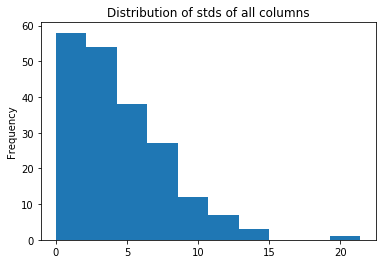

In [4]:
train[train.columns[2:]].std().plot('hist');
plt.title('Distribution of stds of all columns');

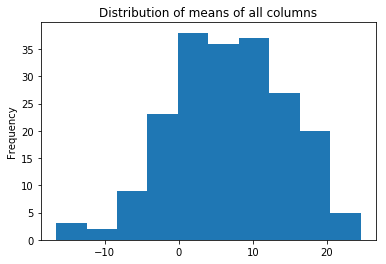

In [5]:
train[train.columns[2:]].mean().plot('hist');
plt.title('Distribution of means of all columns');

In [ ]:
train.head()

In [6]:
# we have no missing values
train.isnull().any().any()

False

Distributions of first 28 columns


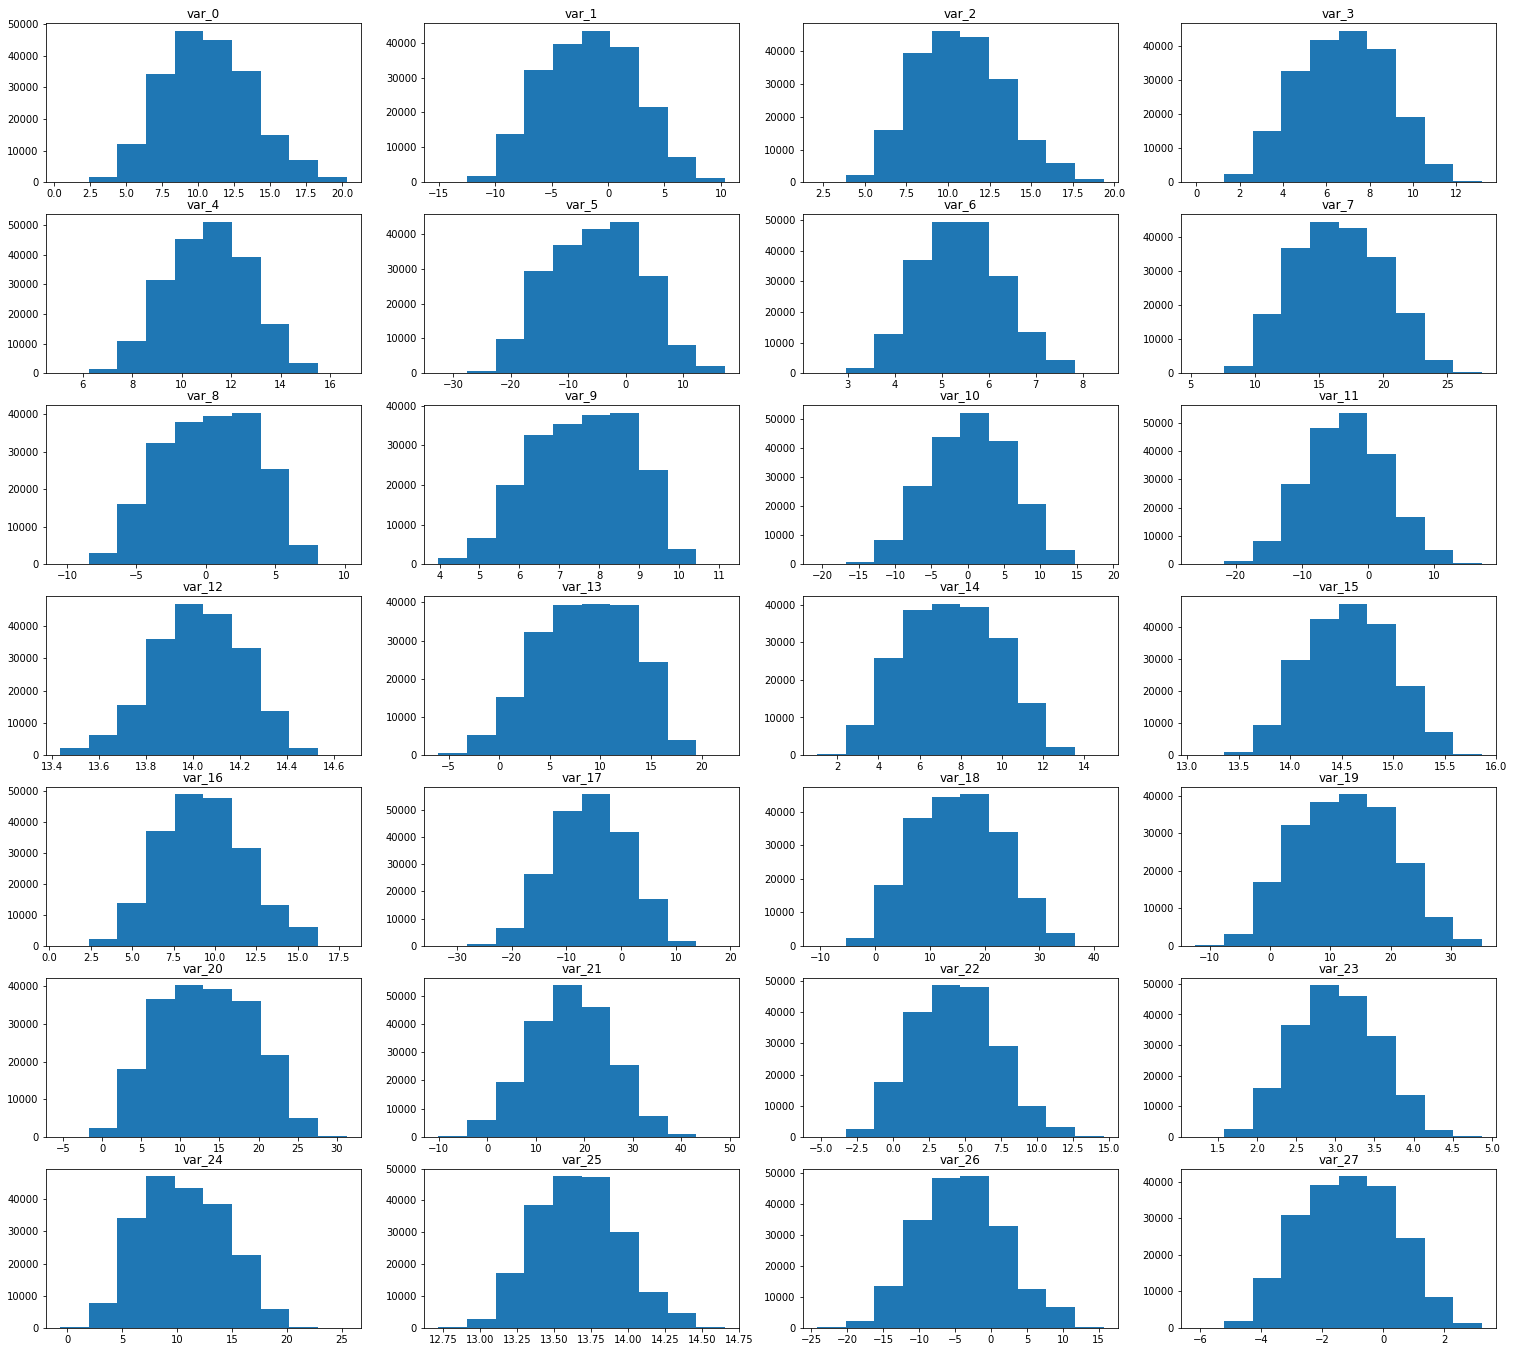

In [7]:
print('Distributions of first 28 columns')
plt.figure(figsize=(26, 24))
for i, col in enumerate(list(train.columns)[2:30]):
    plt.subplot(7, 4, i + 1)
    plt.hist(train[col])
    plt.title(col)

In [4]:
train['target'].value_counts(normalize=True)

0    0.89951
1    0.10049
Name: target, dtype: float64

From this overview we can see the following things:
* target is binary and has disbalance: 10% of samples belong to 1 class;
* values in columns are more or less similar;
* columns have high std (up to 20)
* columns have a high range of means;

Let's have a look at correlations now!

In [5]:
corrs = train.corr().abs().unstack().sort_values(kind="quicksort").reset_index()
corrs = corrs[corrs['level_0'] != corrs['level_1']]
corrs.tail(30)

,level_0,level_1,0
40170,target,var_80,0.057609
40171,var_80,target,0.057609
40172,var_166,target,0.057773
40173,target,var_166,0.057773
40174,var_99,target,0.058367
40175,target,var_99,0.058367
40176,target,var_21,0.058483
40177,var_21,target,0.058483
40178,target,var_22,0.060558
40179,var_22,target,0.060558


In [6]:
corrs.head()

,level_0,level_1,0
0,var_191,var_75,2.703975e-08
1,var_75,var_191,2.703975e-08
2,var_173,var_6,5.942735e-08
3,var_6,var_173,5.942735e-08
4,var_126,var_109,1.313947e-07


We can see that all features have a low correlation with target. So we have no highly correlated features which we could drop, on the other hand we could drop some columns with have little correlation with the target.

## Basic modelling

In [3]:
X = train.drop(['ID_code', 'target'], axis=1)
y = train['target']
X_test = test.drop(['ID_code'], axis=1)
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
repeated_folds = RepeatedStratifiedKFold(n_splits=10, n_repeats=20, random_state=42)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [4]:
def train_model(X, X_test, y, params, folds, model_type='lgb', plot_feature_importance=False, averaging='usual', model=None):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.loc[train_index], X.loc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=20000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=1000,
                    early_stopping_rounds = 200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_train.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X_train.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict_proba(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            # print(f'Fold {fold_n}. AUC: {score:.4f}.')
            # print('')
            
            y_pred = model.predict_proba(X_test)[:, 1]
            
        if model_type == 'glm':
            model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
            model_results = model.fit()
            model_results.predict(X_test)
            y_pred_valid = model_results.predict(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            
            y_pred = model_results.predict(X_test)
            
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=20000, learning_rate=0.05, loss_function='Logloss',  eval_metric='AUC', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test)[:, 1]
            
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))

        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values  
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores

In [5]:
# %%time
# model = linear_model.LogisticRegression(class_weight='balanced', penalty='l2', C=0.1)
# oof_lr, prediction_lr, scores = train_model(X, X_test, y, params=None, folds=folds, model_type='sklearn', model=model)

In [6]:
params = {'num_leaves': 8,
         'min_data_in_leaf': 42,
         'objective': 'binary',
         'max_depth': 16,
         'learning_rate': 0.0123,
         'boosting': 'gbdt',
         'bagging_freq': 5,
         'feature_fraction': 0.8201,
         'bagging_seed': 11,
         'reg_alpha': 1.728910519108444,
         'reg_lambda': 4.9847051755586085,
         'random_state': 42,
         'metric': 'auc',
         'verbosity': -1,
         'subsample': 0.81,
         'min_gain_to_split': 0.01077313523861969,
         'min_child_weight': 19.428902804238373,
         'num_threads': 4}
oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Thu Feb 28 07:18:51 2019
Training until validation scores don't improve for 200 rounds.


KeyboardInterrupt: 

In [18]:
sub = pd.read_csv('../input/sample_submission.csv')
sub.shape

(200000, 2)

In [19]:
sub.head()

,ID_code,target
0,test_0,0
1,test_1,0
2,test_2,0
3,test_3,0
4,test_4,0


In [23]:
sub['target'] = prediction_lgb
sub.to_csv('lgb.csv', index=False)

In [24]:
sub.head()

,ID_code,target
0,test_0,0.077707
1,test_1,0.238362
2,test_2,0.218050
3,test_3,0.161857
4,test_4,0.049789


## ELI5

In [29]:
%%time
model = lgb.LGBMClassifier(**params, n_estimators = 20000, n_jobs = 12)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.884514	valid_1's auc: 0.862324
[2000]	training's auc: 0.90923	valid_1's auc: 0.882301
[3000]	training's auc: 0.920819	valid_1's auc: 0.890082
[4000]	training's auc: 0.927717	valid_1's auc: 0.89407
[5000]	training's auc: 0.932601	valid_1's auc: 0.896092
[6000]	training's auc: 0.936684	valid_1's auc: 0.897173
[7000]	training's auc: 0.94052	valid_1's auc: 0.897628
[8000]	training's auc: 0.944193	valid_1's auc: 0.897815
Early stopping, best iteration is:
[8605]	training's auc: 0.94639	valid_1's auc: 0.897966
CPU times: user 19min 27s, sys: 9.36 s, total: 19min 36s
Wall time: 4min 55s


In [30]:
%%time
model = lgb.LGBMClassifier(**params, n_estimators = 20000, n_jobs = 6)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.88519	valid_1's auc: 0.86058
[2000]	training's auc: 0.910245	valid_1's auc: 0.880468
[3000]	training's auc: 0.921624	valid_1's auc: 0.888347
[4000]	training's auc: 0.928552	valid_1's auc: 0.892528
[5000]	training's auc: 0.93344	valid_1's auc: 0.894496
[6000]	training's auc: 0.937401	valid_1's auc: 0.895488
[7000]	training's auc: 0.941201	valid_1's auc: 0.896064
Early stopping, best iteration is:
[7373]	training's auc: 0.942592	valid_1's auc: 0.89614
CPU times: user 16min 39s, sys: 7.92 s, total: 16min 46s
Wall time: 4min 12s


In [32]:
%%time
model = lgb.LGBMClassifier(**params, n_estimators = 20000, n_jobs = 1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.88578	valid_1's auc: 0.857433
[2000]	training's auc: 0.910326	valid_1's auc: 0.877824
[3000]	training's auc: 0.921916	valid_1's auc: 0.886662
[4000]	training's auc: 0.928717	valid_1's auc: 0.890966
[5000]	training's auc: 0.933379	valid_1's auc: 0.893432
[6000]	training's auc: 0.937389	valid_1's auc: 0.894839
[7000]	training's auc: 0.941195	valid_1's auc: 0.895302
[8000]	training's auc: 0.944937	valid_1's auc: 0.89565
Early stopping, best iteration is:
[8601]	training's auc: 0.947007	valid_1's auc: 0.895837
CPU times: user 18min 23s, sys: 8.62 s, total: 18min 32s
Wall time: 4min 38s


In [7]:
%%time
model = lgb.LGBMClassifier(**params, n_estimators = 20000, n_jobs = -1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.884785	valid_1's auc: 0.859322
[2000]	training's auc: 0.90961	valid_1's auc: 0.880121
[3000]	training's auc: 0.921246	valid_1's auc: 0.888189
[4000]	training's auc: 0.928151	valid_1's auc: 0.892631
[5000]	training's auc: 0.933126	valid_1's auc: 0.894682
[6000]	training's auc: 0.937132	valid_1's auc: 0.895865
[7000]	training's auc: 0.941035	valid_1's auc: 0.896323
Early stopping, best iteration is:
[7317]	training's auc: 0.942219	valid_1's auc: 0.896451
CPU times: user 14min 41s, sys: 7.06 s, total: 14min 48s
Wall time: 3min 42s


In [33]:
eli5.show_weights(model, targets=[0, 1], feature_names=list(X_train.columns), top=40, feature_filter=lambda x: x != '<BIAS>')

Weight,Feature
0.0259,var_81
0.0207,var_139
0.0189,var_12
0.0170,var_53
0.0165,var_110
0.0164,var_6
0.0160,var_174
0.0156,var_26
0.0144,var_146
0.0141,var_166


ELI5 didn't help up to eliminate features, but let's at least try to take top-100 and see how it helps.

In [34]:
top_features = [i for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i][:100]
X1 = X[top_features]
X_train, X_valid, y_train, y_valid = train_test_split(X1, y, test_size=0.2, stratify=y)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.884433	valid_1's auc: 0.86333
[2000]	training's auc: 0.905471	valid_1's auc: 0.878397
[3000]	training's auc: 0.91334	valid_1's auc: 0.88242
[4000]	training's auc: 0.917636	valid_1's auc: 0.883758
[5000]	training's auc: 0.92099	valid_1's auc: 0.884234
Early stopping, best iteration is:
[4889]	training's auc: 0.920567	valid_1's auc: 0.884278


LGBMClassifier(bagging_freq=5, bagging_seed=11, boosting='gbdt',
        boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        feature_fraction=0.8201, importance_type='split',
        learning_rate=0.0123, max_depth=16, metric='auc',
        min_child_samples=20, min_child_weight=19.428902804238373,
        min_data_in_leaf=42, min_gain_to_split=0.01077313523861969,
        min_split_gain=0.0, n_estimators=20000, n_jobs=1, num_leaves=8,
        num_threads=4, objective='binary', random_state=42,
        reg_alpha=1.728910519108444, reg_lambda=4.9847051755586085,
        silent=True, subsample=0.81, subsample_for_bin=200000,
        subsample_freq=0, verbosity=-1)

In [35]:
def calculate_metrics(model, X_train: pd.DataFrame() = None, y_train: pd.DataFrame() = None, X_valid: pd.DataFrame() = None,
                      y_valid: pd.DataFrame() = None, columns: list = []) -> pd.DataFrame():
    columns = columns if len(columns) > 0 else list(X_train.columns)
    train_pred = model.predict_proba(X_train[columns])
    valid_pred = model.predict_proba(X_valid[columns])
    f1 = 0
    best_t = 0
    for t in np.arange(0.1, 1, 0.05):
        valid_pr = (valid_pred[:, 1] > t).astype(int)
        valid_f1 = metrics.f1_score(y_valid, valid_pr)
        if valid_f1 > f1:
            f1 = valid_f1
            best_t = t

    t = best_t
    train_pr = (train_pred[:, 1] > t).astype(int)
    valid_pr = (valid_pred[:, 1] > t).astype(int)
    train_f1 = metrics.f1_score(y_train, train_pr)
    valid_f1 = metrics.f1_score(y_valid, valid_pr)
    score_df = []
    print(f'Best threshold: {t:.2f}. Train f1: {train_f1:.4f}. Valid f1: {valid_f1:.4f}.')
    score_df.append(['F1', np.round(train_f1, 4), np.round(valid_f1, 4)])
    train_r = metrics.recall_score(y_train, train_pr)
    valid_r = metrics.recall_score(y_valid, valid_pr)

    score_df.append(['Recall', np.round(train_r, 4), np.round(valid_r, 4)])
    train_p = metrics.precision_score(y_train, train_pr)
    valid_p = metrics.precision_score(y_valid, valid_pr)

    score_df.append(['Precision', np.round(train_p, 4), np.round(valid_p, 4)])
    train_roc = metrics.roc_auc_score(y_train, train_pred[:, 1])
    valid_roc = metrics.roc_auc_score(y_valid, valid_pred[:, 1])

    score_df.append(['ROCAUC', np.round(train_roc, 4), np.round(valid_roc, 4)])
    train_apc = metrics.average_precision_score(y_train, train_pred[:, 1])
    valid_apc = metrics.average_precision_score(y_valid, valid_pred[:, 1])

    score_df.append(['APC', np.round(train_apc, 4), np.round(valid_apc, 4)])
    print(metrics.confusion_matrix(y_valid, valid_pr))
    score_df = pd.DataFrame(score_df, columns=['Metric', 'Train', 'Valid'])
    print(score_df)

    return score_df, t

In [36]:
_ = calculate_metrics(model, X_train, y_train, X_valid, y_valid)

Best threshold: 0.30. Train f1: 0.6248. Valid f1: 0.5452.
[[34533  1447]
 [ 1971  2049]]
      Metric   Train   Valid
0         F1  0.6248  0.5452
1     Recall  0.5930  0.5097
2  Precision  0.6601  0.5861
3     ROCAUC  0.9206  0.8843
4        APC  0.6897  0.5794


## Feature generation

### Feature interaction

In [42]:
X = train.drop(['ID_code', 'target'], axis=1)
X_test = test.drop(['ID_code'], axis=1)

columns = top_features = [i for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i][:20]
for col1 in tqdm_notebook(columns):
    for col2 in columns:
        X[col1 + '_' + col2] = X[col1] * X[col2]   
        X_test[col1 + '_' + col2] = X_test[col1] * X_test[col2]

In [43]:
eli5.formatters.as_dataframe.explain_weights_df(model).feature

0      var_81
1     var_139
2      var_12
3     var_110
4      var_53
5      var_26
6       var_6
7     var_174
8     var_146
9      var_22
10     var_80
11    var_166
12     var_76
13     var_21
14     var_99
15    var_109
16     var_13
17    var_165
18     var_78
19    var_190
20    var_133
21    var_148
22     var_34
23      var_2
24      var_0
25    var_198
26     var_40
27    var_179
28      var_1
29     var_44
       ...   
70     var_93
71    var_106
72    var_163
73    var_197
74     var_32
75    var_162
76    var_130
77    var_145
78     var_71
79     var_49
80    var_119
81    var_131
82    var_141
83    var_150
84    var_167
85    var_125
86     var_48
87     var_51
88    var_137
89    var_186
90    var_128
91    var_151
92    var_135
93     var_52
94     var_43
95     var_24
96    var_132
97    var_195
98    var_114
99    var_111
Name: feature, Length: 100, dtype: object

Fold 0 started at Wed Feb 27 19:11:07 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.885014	valid_1's auc: 0.864492
[2000]	training's auc: 0.909721	valid_1's auc: 0.882867
[3000]	training's auc: 0.921202	valid_1's auc: 0.89042
[4000]	training's auc: 0.928088	valid_1's auc: 0.89445
[5000]	training's auc: 0.932895	valid_1's auc: 0.896647
[6000]	training's auc: 0.936977	valid_1's auc: 0.897681
[7000]	training's auc: 0.940894	valid_1's auc: 0.898105
[8000]	training's auc: 0.944607	valid_1's auc: 0.898296
Early stopping, best iteration is:
[8530]	training's auc: 0.946556	valid_1's auc: 0.898392
Fold 1 started at Wed Feb 27 19:16:35 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.884713	valid_1's auc: 0.864687
[2000]	training's auc: 0.90936	valid_1's auc: 0.883356
[3000]	training's auc: 0.921266	valid_1's auc: 0.891113
[4000]	training's auc: 0.928168	valid_1's auc: 0.895326
[5000]	training's auc: 0.932

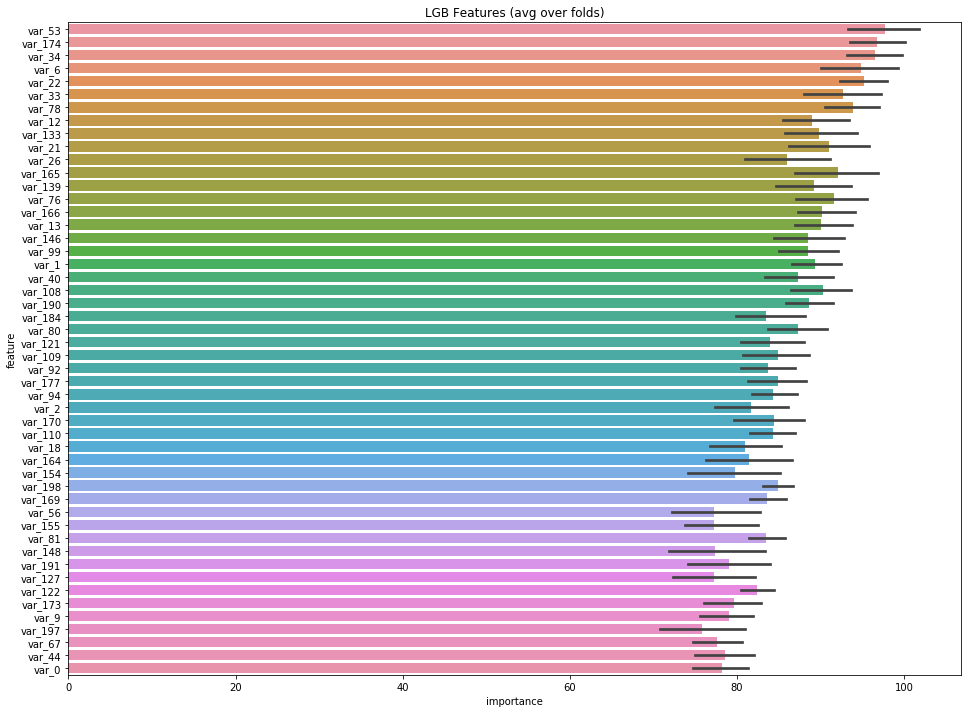

In [45]:
oof_lgb, prediction_lgb_inter, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

In [46]:
sub = pd.read_csv('../input/sample_submission.csv')
sub['target'] = prediction_lgb_inter
sub.to_csv('lgb_inter.csv', index=False)

### Scaling

! **Notice** scaling severely decreases score

In [47]:
sub

,ID_code,target
0,test_0,0.999924
1,test_1,0.999877
2,test_2,0.999920
3,test_3,0.999908
4,test_4,0.999929
5,test_5,0.999894
6,test_6,0.999847
7,test_7,0.999843
8,test_8,0.999888
9,test_9,0.999812


In [44]:
X = train.drop(['ID_code', 'target'], axis=1)
X_test = test.drop(['ID_code'], axis=1)
scaler = StandardScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_test[X_train.columns] = scaler.transform(X_test[X_train.columns])
# oof_lgb, prediction_lgb_scaled, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)
# sub = pd.read_csv('../input/sample_submission.csv')
# sub['target'] = prediction_lgb_scaled
# sub.to_csv('lgb_scaled.csv', index=False)

### Statistics

In [ ]:
# X = train.drop(['ID_code', 'target'], axis=1)
# X_test = test.drop(['ID_code'], axis=1)

# X['std'] = X.std(1)
# X_test['std'] = X_test.std(1)

# X['mean'] = X.mean(1)
# X_test['mean'] = X_test.mean(1)
# oof_lgb, prediction_lgb_stats, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)
# sub = pd.read_csv('../input/sample_submission.csv')
# sub['target'] = prediction_lgb_stats
# sub.to_csv('lgb_stats.csv', index=False)

Training with these features gives the same score on LB: 0.899

### NN features

Takes several hours.

In [ ]:
# %%time
# X = train.drop(['ID_code', 'target'], axis=1)
# X_test = test.drop(['ID_code'], axis=1)
# neigh = NearestNeighbors(3, n_jobs=-1)
# neigh.fit(X)

# dists, _ = neigh.kneighbors(X, n_neighbors=3)
# mean_dist = dists.mean(axis=1)
# max_dist = dists.max(axis=1)
# min_dist = dists.min(axis=1)

# X['mean_dist'] = mean_dist
# X['max_dist'] = max_dist
# X['min_dist'] = min_dist

# test_dists, _ = neigh.kneighbors(X_test, n_neighbors=3)

# test_mean_dist = test_dists.mean(axis=1)
# test_max_dist = test_dists.max(axis=1)
# test_min_dist = test_dists.min(axis=1)

# X_test['mean_dist'] = test_mean_dist
# X_test['max_dist'] = test_max_dist
# X_test['min_dist'] = test_min_dist

# oof_lgb, prediction_lgb_dist, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)
# sub = pd.read_csv('../input/sample_submission.csv')
# sub['target'] = prediction_lgb_dist
# sub.to_csv('lgb_dist.csv', index=False)

## Blend

In [ ]:
# xgb_params = {'eta': 0.05, 'max_depth': 3, 'subsample': 0.9, 'colsample_bytree': 0.9, 
#           'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'nthread': 4}
# oof_xgb, prediction_xgb, scores = train_model(X, X_test, y, params=xgb_params, folds=folds, model_type='xgb')

In [ ]:
# cat_params = {'depth': 13,
#               'l2_leaf_reg': 10,
#               'bootstrap_type': 'Bernoulli',
#               #'metric_period': 500,
#               'od_type': 'Iter',
#               'od_wait': 50,
#               'random_seed': 11,
#               'allow_writing_files': False}
# oof_cat, prediction_cat, _ = train_model(X, X_test, y, params=cat_params, folds=folds, model_type='cat')

In [ ]:
# sub['target'] = (prediction_lgb + prediction_xgb) / 2
# sub.to_csv('blend1.csv', index=False)
# sub['target'] = (prediction_lgb + prediction_xgb + prediction_cat) / 3
# sub.to_csv('blend2.csv', index=False)